## Notebook to prepare the GLORYS2V3 data to be able to save the datasets locally

The next step would be to create the datasets for lateral forcing.

In this notebook:
- Annual values are obtained
- A new dataset with lat and lon as dimensions is obtained
- The area is shrinked to the domain 32°N to 66°N and -24°W to 14°E

The GLORYS2V3 data is:
- 1993-2013
- Monthly
- 1/4°x1/4°,

The GLORYS12V1 data is downloaded from Dewi's work station: /net/pc200008/nobackup/users/bars/GLORYS2V3


 

In [41]:
# Import necessary packages

import ast
import json
import numpy as np
#import xesmf as xe
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from tqdm import tqdm

In [64]:
# Import GLORYS2V3
Glorys2v3_SSH = xr.open_mfdataset('/Users/iriskeizer/Documents/ROMS/data/GLORYS2V3/SSH/*.nc', parallel = True)
Glorys2v3_GRID2D = xr.open_mfdataset('/Users/iriskeizer/Documents/ROMS/data/GLORYS2V3/GRID2D/*.nc', parallel = True)

# Add the two datasets
Glorys2v3_m = xr.concat([Glorys2v3_GRID2D, Glorys2v3_SSH], dim = 'time_counter')

# Obtain annual values
Glorys2v3 = Glorys2v3_m.groupby('time_counter.year').mean()

# Change variable name 
Glorys2v3 = Glorys2v3.rename({'sossheig':'slh'})

# Shrink spatial extent
Glorys2v3 = Glorys2v3.where((32 < Glorys2v3.nav_lat) & (66 > Glorys2v3.nav_lat) & (-24 < Glorys2v3.nav_lon) & (14 > Glorys2v3.nav_lon), drop = True)

# Add attributes
Glorys2v3.slh.attrs['units'] = "m"
Glorys2v3.slh.attrs['long name'] = "Sea level height above the geoid"
Glorys2v3.nav_lat.attrs['units'] = '°'
Glorys2v3.nav_lon.attrs['units'] = '°'

# Save data
Glorys2v3.to_netcdf('/Users/iriskeizer/Documents/ROMS/data/GLORYS2V3/GLORYS2V3_shr.nc')

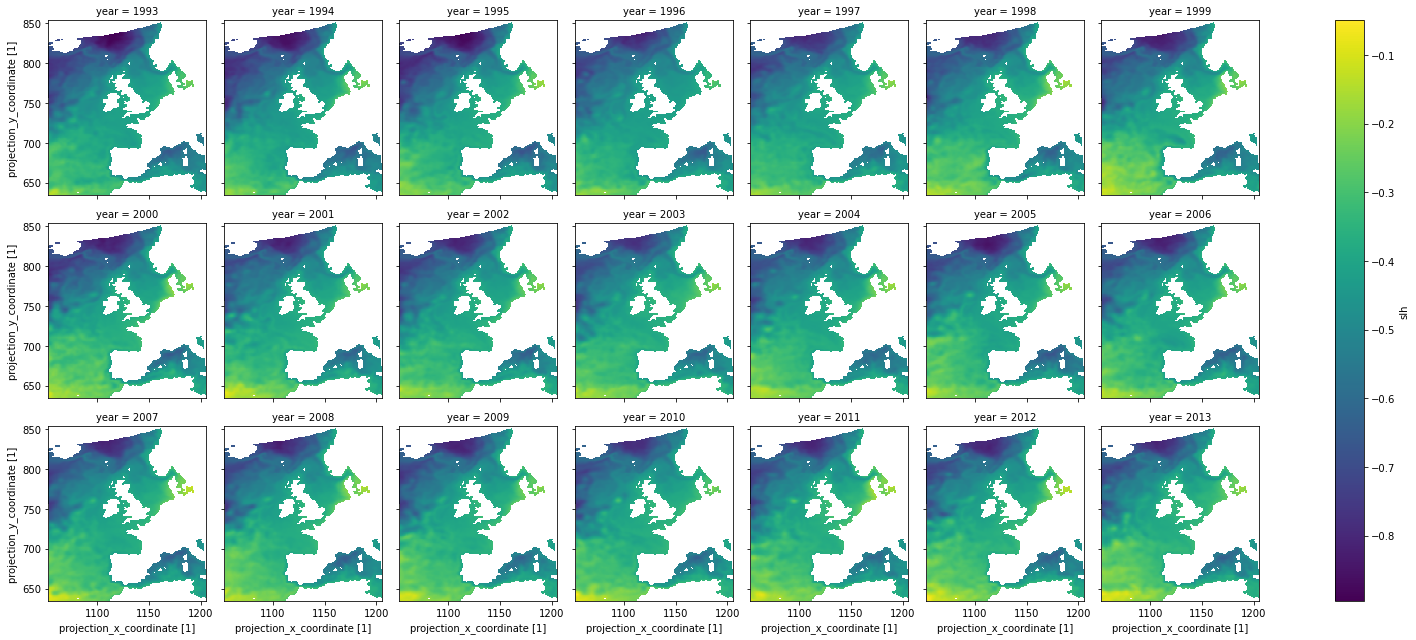

In [61]:
Glorys2v3.slh.plot(col = 'year', col_wrap = 7)

#### Obtain dictionaries to transfrom x,y to lat,lon

In [19]:
#lats = [lst[0] for lst in Glorys2v3.nav_lat.values]
lats = np.arange(-90+180/(1021*2), 90, 180/1021)
lons = list(Glorys2v3.nav_lon.values[0])
years = Glorys2v3.year.values

In [43]:
Glorys2v3.where(Glorys2v3.nav_lat > 32, drop = True)

<xarray.Dataset>
Dimensions:   (year: 21, y: 387, x: 1440, deptht: 1)
Coordinates:
  * deptht    (deptht) float32 1.0
    nav_lat   (y, x) float32 31.65 31.65 31.65 31.65 ... 50.12 50.07 50.02 50.0
    nav_lon   (y, x) float32 73.0 73.25 73.5 73.75 ... 73.01 73.01 73.01 73.0
  * x         (x) int32 2 3 4 5 6 7 8 9 ... 1435 1436 1437 1438 1439 1440 1441
  * y         (y) int32 635 636 637 638 639 640 ... 1017 1018 1019 1020 1021
  * year      (year) int64 1993 1994 1995 1996 1997 ... 2009 2010 2011 2012 2013
Data variables:
    sossheig  (year, y, x) float32 dask.array<chunksize=(1, 387, 1440), meta=np.ndarray>

In [50]:
Glorys2v3_shr = Glorys2v3.where((32 < Glorys2v3.nav_lat) & (66 > Glorys2v3.nav_lat) & (-24 < Glorys2v3.nav_lon) & (14 > Glorys2v3.nav_lon), drop = True)

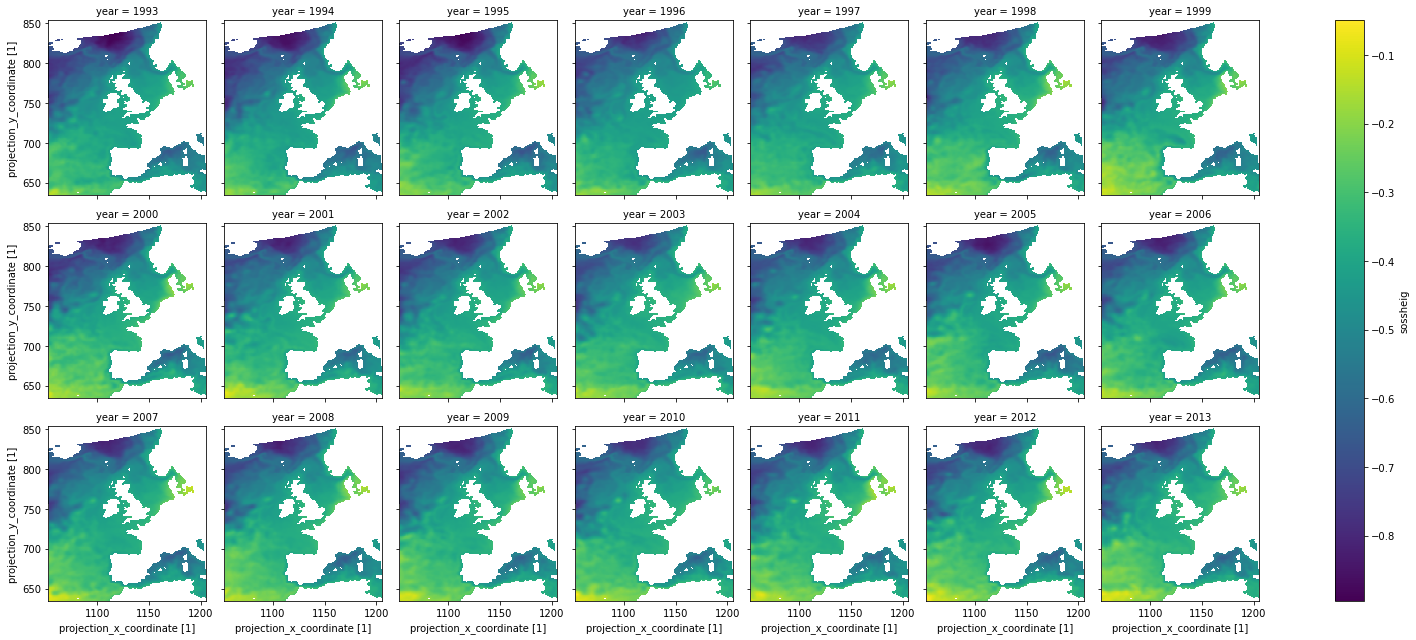

In [51]:
Glorys2v3_shr.sossheig.plot(col = 'year', col_wrap = 7)

In [ ]:
# Save this dataset
Glorys2v3_shr.to_netcdf('/Users/iriskeizer/Documents/ROMS/data/GLORYS2V3/GLORYS2V3_shr.nc')

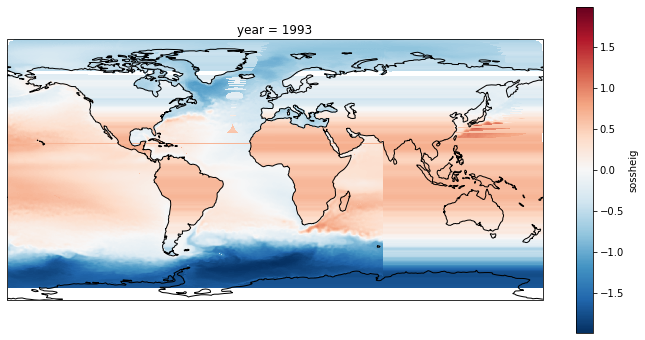

In [36]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
Glorys2v3.sossheig[0].plot.pcolormesh(ax=ax, x="nav_lon", y="nav_lat")
ax.coastlines()


Text(0, 0.5, 'lat')

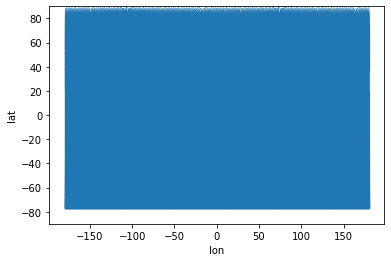

In [37]:
plt.scatter(Glorys2v3["nav_lon"], Glorys2v3["nav_lat"], s=0.01)  # plot grid locations
plt.ylim([-90, 90])
plt.xlabel("lon")
plt.ylabel("lat")

In [39]:
# Rename variable names
ds = Glorys2v3
ds = ds.rename({"nav_lon": "lon", "nav_lat": "lat"})
ds

<xarray.Dataset>
Dimensions:   (deptht: 1, y: 1021, x: 1440, year: 21)
Coordinates:
  * deptht    (deptht) float32 1.0
    lat       (y, x) float32 -77.01 -77.01 -77.01 -77.01 ... 50.07 50.02 50.0
    lon       (y, x) float32 73.0 73.25 73.5 73.75 ... 73.01 73.01 73.01 73.0
  * x         (x) int32 2 3 4 5 6 7 8 9 ... 1435 1436 1437 1438 1439 1440 1441
  * y         (y) int32 1 2 3 4 5 6 7 8 ... 1015 1016 1017 1018 1019 1020 1021
  * year      (year) int64 1993 1994 1995 1996 1997 ... 2009 2010 2011 2012 2013
Data variables:
    sossheig  (year, y, x) float32 dask.array<chunksize=(1, 1021, 1440), meta=np.ndarray>

In [103]:

GLORYS2V3 = xr.Dataset(
    data_vars = dict(
        slh = (["year", "lat", "lon"], Glorys2v3.sossheig.values)
    ),
    coords = dict(
        year = (["year"], years),
        lat = (["lat"], lats),
        lon = (["lon"], lons),
    ),
    attrs = dict(
        description = "GLORYS2v3 data from Dewi",
    )    
)
    
GLORYS2V3.slh.attrs['units'] = "m"
GLORYS2V3.slh.attrs['long name'] = "Sea level height above the geoid"


GLORYS2V3 = GLORYS2V3.sortby('lat')
GLORYS2V3 = GLORYS2V3.sortby('lon')

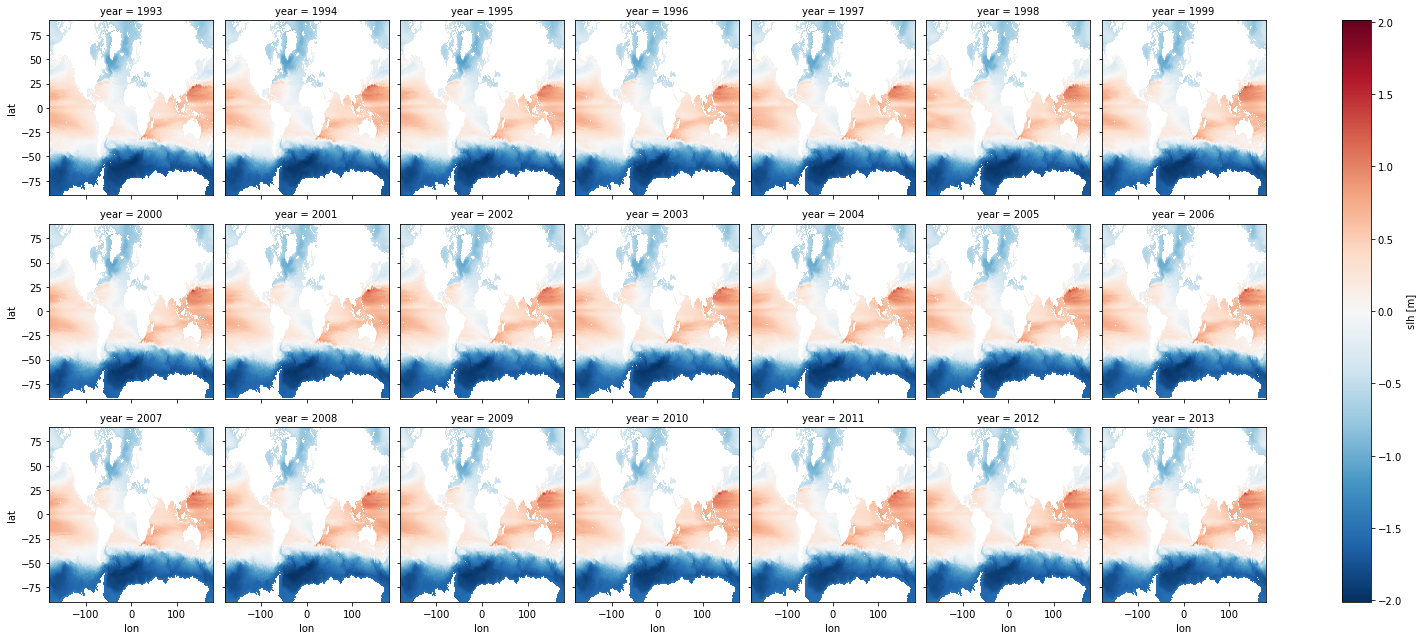

In [104]:
GLORYS2V3.slh.plot(col = 'year', col_wrap = 7)

In [105]:
def shrink_region(data):
    '''
    Function to shrink the spatial region of the data from global to the ROMS region (32°N to 66°N and -24°W to 14°E)
    
    '''
    
    data_shr = data.where((data.lat > 32) & (data.lat < 66) & (data.lon > -24 ) & (data.lon < 14) , drop = True) # Select region
    

    
    return data_shr

In [106]:
GLORYS2V3_shr = shrink_region(GLORYS2V3)

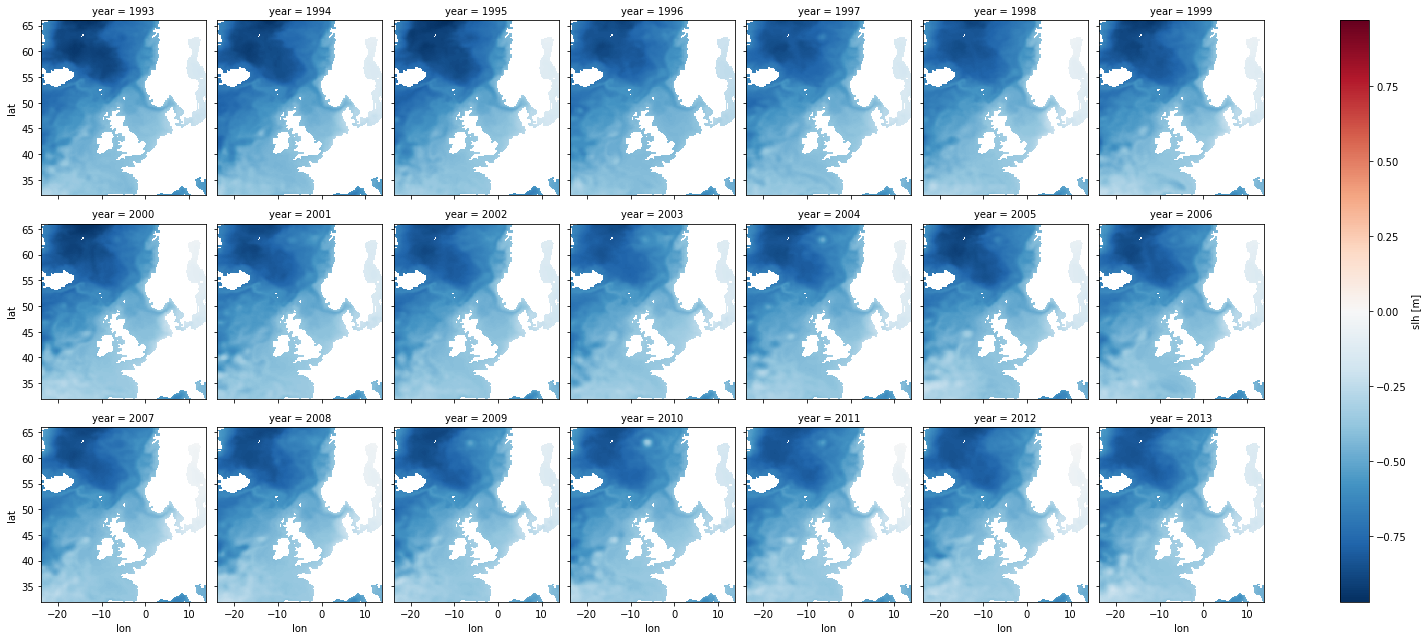

In [107]:
GLORYS2V3_shr.slh.plot(col = 'year', col_wrap = 7)

In [108]:
# Save the dataset
GLORYS2V3_shr.to_netcdf('/Users/iriskeizer/Documents/ROMS/data/GLORYS2V3/GLORYS2V3_shr.nc')

In [159]:
lats = [lst[0] for lst in roms_output_tim.lat_rho.values]
lons = list(roms_output_tim.lon_rho.values[0])


In [176]:
ROMS_output_tim = xr.Dataset(
    data_vars = dict(
        slh = (["year", "lat", "lon"], roms_output_tim.zeta.values)
    ),
    coords = dict(
        year = (["year"], years),
        lat = (["lat"], lats),
        lon = (["lon"], lons),
    ),
    attrs = dict(
        description = "ROMS slh output from Tim",
    )    
)
    
ROMS_output_tim.slh.attrs['units'] = "m"
ROMS_output_tim.slh.attrs['long name'] = "Sea level height above the geoid"

  0%|                                                    | 0/26 [11:25<?, ?it/s]


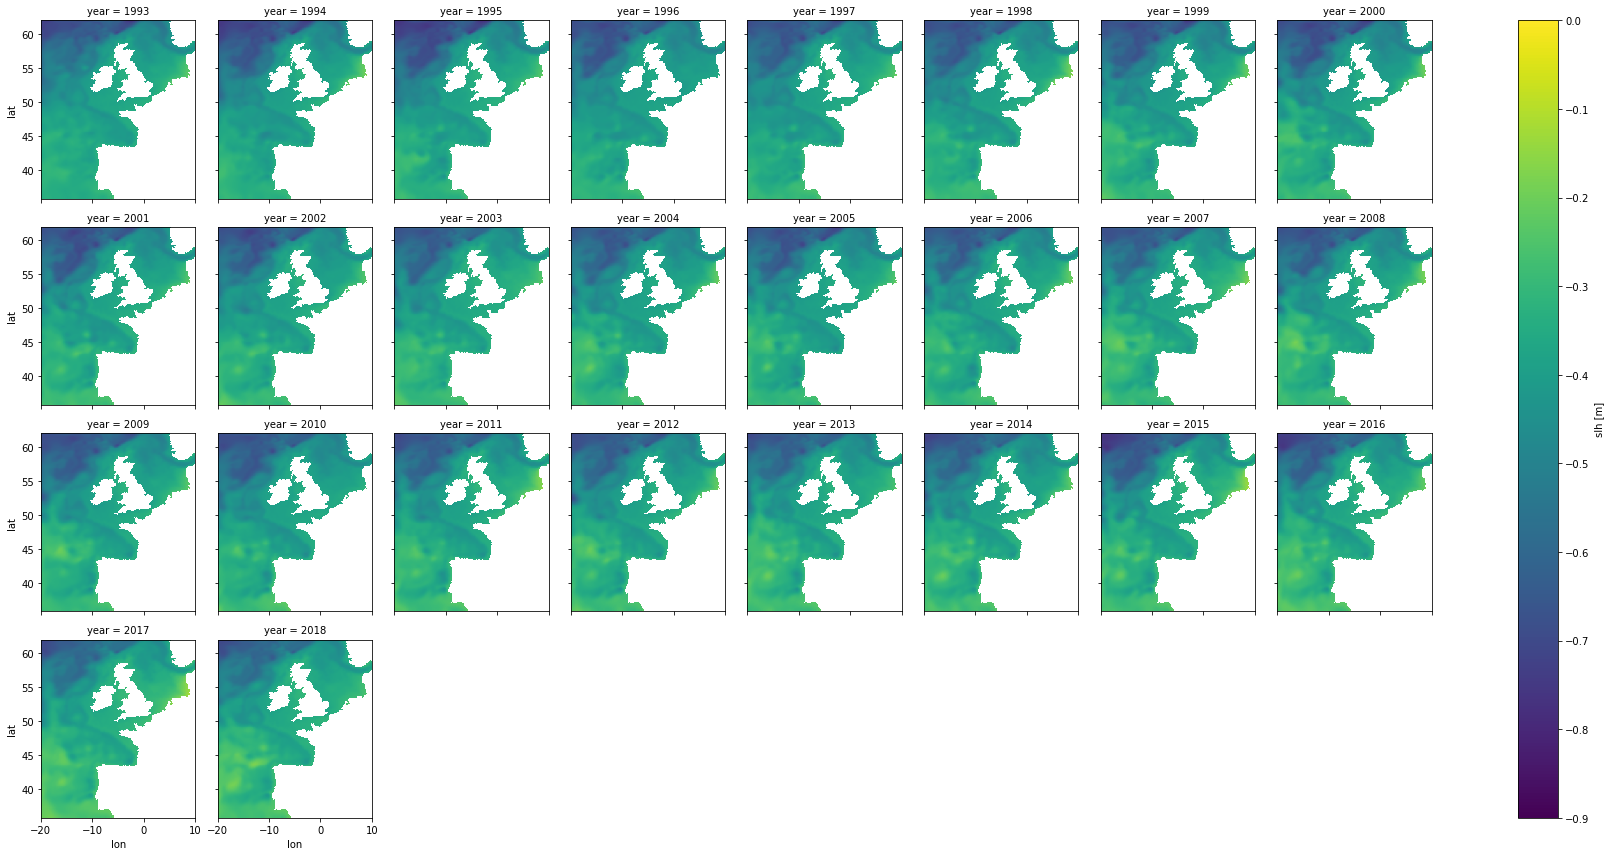

In [178]:
ROMS_output_tim.slh.plot(col = 'year', col_wrap = 8, vmin = -0.9, vmax = 0) # Sea level [m]

In [ ]:
coord_dict_xy = {}
coord_dict_ll = {}

lats = []
lons = []

for x in tqdm(Glorys2v3.x.values):
    for y in Glorys2v3.y.values:
        data = Glorys2v3.loc[dict(x=x, y=y)]
        lat = float(data.nav_lat)
        lon = float(data.nav_lon)
        coord_dict_xy[(x,y)] = (lat, lon)
        coord_dict_ll[(lat, lon)] = (x,y)
        if lat not in lats:
            lats.append(lat)
        if lon not in lons:
            lons.append(lon)

In [ ]:
# open file for writing
f1 = open("/Users/iriskeizer/Documents/ROMS/data/GLORYS2V3/Conversion dictionaries/coord_dict_xy.txt","w")
f2 = open("/Users/iriskeizer/Documents/ROMS/data/GLORYS2V3/Conversion dictionaries/coord_dict_ll.txt","w")

# write file
f1.write( str(coord_dict_xy) )
f2.write( str(coord_dict_ll) )

# close file
f1.close()
f2.close()



#### Create new dataset with lat and lon as dimensions

In [ ]:
# Import conversion dictionaries
f_xy = open(r"/Users/iriskeizer/Documents/ROMS/data/GLORYS2V3/Conversion dictionaries/coord_dict_xy.txt","r")
f_ll = open(r"/Users/iriskeizer/Documents/ROMS/data/GLORYS2V3/Conversion dictionaries/coord_dict_ll.txt","r")

f_xy = f_xy.read()
f_ll = f_ll.read()

In [19]:
coord_dict_xy = ast.literal_eval(f_xy)
coord_dict_ll = ast.literal_eval(f_ll)

In [117]:
# Obtain lats and lons
lats = []
lons = []
for lat, lon in coord_dict_ll:
    
    if lat not in lats:
        lats.append(lat)
    if lon not in lons:
        lons.append(lon)

In [ ]:
# Change the GLORYS2V3 dataset currently having dimensions (year, y, x) into an array having dimensions (year, lat, lon)
years = Glorys2v3.year.values


slh_arr = [[[float(Glorys2v3.loc[dict(x=x, y=y, year = year)].sossheig) for lon in lons[:30] if (lat,lon) in coord_dict_ll] for lat in tqdm(lats[:40])] for year in tqdm(years[:20])]

In [ ]:
# Change the GLORYS2V3 dataset currently having dimensions (year, y, x) into an array having dimensions (year, lat, lon)

years = Glorys2v3.year.values
slh_arr = []

for year in tqdm(years[:2]):
    slh_lst_x = []
    
    for lat in tqdm(lats[:4]):
        slh_lst_y = []
        
        for lon in lons[:3]:
            
            if (lat,lon) in coord_dict_ll:
                x,y = coord_dict_ll[lat, lon]
            
                data = Glorys2v3.loc[dict(x=x, y=y, year = year)]
            
                slh_lst_y.append(float(data.sossheig))
                
            else:
                slh_lst_y.append(np.nan)
                
        slh_lst_x.append(slh_lst_y)

    slh_arr.append(slh_lst_x)


In [94]:
GLORYS2v3 = xr.Dataset(
    data_vars = dict(
        slh = (["year", "lat", "lon"], slh_arr)
    ),
    coords = dict(
        year = (["year"], years),
        lat = (["lat"], lats),
        lon = (["lon"], lons),
    ),
    attrs = dict(
        description = "GLORYS2v3 data from Dewi",
    )    
)
    
GLORYS2v3.slh.attrs['units'] = "m"
GLORYS2v3.slh.attrs['long name'] = "Sea level height above the geoid"

In [68]:
GLORYS2v3.slh.plot(col = 'year', col_wrap = 8)

<xarray.DataArray 'slh' (year: 10, lat: 7, lon: 5)>
array([[[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]],

       [[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]],

       [[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
...
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]],

       [[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]],

       [[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]]])
Coordinates:
  * year     (year) int64 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
  * lat      (lat) float64 -77.01 -76.95 -76.9 -76.84 -76.78 -76.73 -76.67
  * lon      (lon) float64 73.0 73.0 73.0 73.0 73.0

In [38]:
# Try out dataset construction
years = [2001, 2002, 2003, 2004]
lats = [50, 55, 60]
lons = [0, 5]

slh_arr = [[[0,1], [4,5], [8,9]], [[2,3], [6,7], [10,11]], [[3,4], [8,8], [8, 11]], [[1,2], [3,3], [6,6]]]


ds_slh = xr.Dataset(
    data_vars = dict(
        slh = (["year", "lat", "lon"], slh_arr)
    ),
    coords = dict(
        year = (["year"], years),
        lat = (["lat"], lats),
        lon = (["lon"], lons),
    ),
)

#### Perform other preparation steps

In [ ]:
# Make extent of the Glorys12v1 data similar to ROMS
GLORYS2v3 = Glorys2v3.where((glorys12v1.nav_lat > 36) & (glorys12v1.nav_lat < 62) & (glorys12v1.nav_lon > -20) & (glorys12v1.nav_lon < 10), drop = True)